In [11]:
!pip install albumentations as A
!pip install albumentations.pytorch import ToTensorV2
!pip install numpy as np
!pip install nibabel
!pip install torch
!pip install tensorflow
!pip install nibabel as nib

%pip install nibabel
%pip install opencv-python
%pip install albumentations
%pip install segmentation_models_pytorch


import nibabel as nib
from torch.utils.data import Dataset
import tensorflow as tf
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

print(f"Step 1: Installation and imports done")


ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement albumentations.pytorch (from versions: none)
ERROR: No matching distribution found for albumentations.pytorch
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
Step 1: Installation and imports done


In [66]:
print(f"Step 2: Setting path and method defenitions ")
DATA_DIR = "/content/drive/My Drive/data/ISLES-2022"  # or your actual data folder path
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def get_train_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ElasticTransform(p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=0, std=1, max_pixel_value=1.0),
        ToTensorV2()
    ])

class ISLESDataset3D(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        print(f"entering to extract 3D samples")
        mask_root = os.path.join(root_dir, "derivatives")
        for subject in os.listdir(root_dir):
            if subject.startswith("sub-"):
                ses_dir = os.path.join(root_dir, subject, "ses-0001")
                if os.path.exists(ses_dir):
                    dwi_dir = os.path.join(ses_dir, "dwi")
                    anat_dir = os.path.join(ses_dir, "anat")
                    dwi_path = [f for f in os.listdir(dwi_dir) if f.endswith("_dwi.nii.gz")]
                    flair_path = [f for f in os.listdir(anat_dir) if f.endswith("_FLAIR.nii.gz")]
                    mask_dir = os.path.join(mask_root, subject, "ses-0001")
                    mask_path = []
                    if os.path.exists(mask_dir):
                        mask_path = [f for f in os.listdir(mask_dir) if f.endswith(".nii.gz")]
                    if dwi_path and flair_path and mask_path:
                        self.samples.append({
                            "dwi": os.path.join(dwi_dir, dwi_path[0]),
                            "flair": os.path.join(anat_dir, flair_path[0]),
                            "mask": os.path.join(mask_dir, mask_path[0])
                        })
        print(f"Total 3D samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        dwi_nifti = nib.load(sample["dwi"])
        flair_nifti = nib.load(sample["flair"])
        mask_nifti = nib.load(sample["mask"])

        dwi = np.asarray(dwi_nifti.get_fdata(), dtype=np.float32)
        flair = np.asarray(flair_nifti.get_fdata(), dtype=np.float32)
        mask = np.asarray(mask_nifti.get_fdata(), dtype=np.float32)

        # Ensure mask is binary
        mask = (mask > 0.5).astype(np.float32)

        # --- Alignment Step ---
        # A simple approach is to resample to a common grid.
        # A more robust approach would use the affine matrices.
        # For simplicity and assuming relatively aligned data,
        # we'll resample DWI and FLAIR to the mask's grid and shape.
        # This requires scikit-image or similar libraries for resampling.
        # Let's demonstrate a simplified approach assuming approximate alignment
        # and focusing on padding/cropping consistently.

        # --- Consistent Cropping/Padding based on a target shape (used later) ---
        # Instead of minimum shape, let's aim for a fixed target shape.
        # The padding and cropping will be handled in the collate function.

        # Stack the images (before padding/cropping here)
        x = np.stack([dwi, flair], axis=0)  # [2, H, W, D]
        y = mask # [H, W, D]

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    @staticmethod
    def load_nifti(path):
         # This method can remain for initial loading if needed elsewhere,
         # but the logic is moved to __getitem__ for better control.
        return np.asarray(nib.load(path).get_fdata(), dtype=np.float32)

class ResidualDoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
        # Optional: Add a 1x1x1 convolution if in_channels != out_channels for the skip connection
        self.residual_conv = nn.Identity()
        if in_channels != out_channels:
            self.residual_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)


    def forward(self, x):
        identity = self.residual_conv(x)
        out = self.double_conv(x)
        return out + identity # Add the residual connection

# In your UNet3D, you would then use ResidualDoubleConv3D
class UNet3D_Improved(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        # Down part
        for feature in features:
            # Use ResidualDoubleConv3D here
            self.downs.append(ResidualDoubleConv3D(in_channels, feature))
            in_channels = feature
        # Use ResidualDoubleConv3D for bottleneck
        self.bottleneck = ResidualDoubleConv3D(features[-1], features[-1]*2)
        in_channels = features[-1]*2  # after bottleneck

        # Up part
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose3d(in_channels, feature, kernel_size=2, stride=2))
            # Use ResidualDoubleConv3D here
            self.ups.append(ResidualDoubleConv3D(feature * 2, feature))
            in_channels = feature  # update for next up block

        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool3d(x, 2)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx // 2]
            # Pad if needed
            diffD = skip.shape[2] - x.shape[2]
            diffH = skip.shape[3] - x.shape[3]
            diffW = skip.shape[4] - x.shape[4]
            x = F.pad(
                x,
                [diffW // 2, diffW - diffW // 2,
                 diffH // 2, diffH - diffH // 2,
                 diffD // 2, diffD - diffD // 2]
            )
            # Crop if needed (for negative diffs)
            if x.shape[2] > skip.shape[2]:
                x = x[:, :, :skip.shape[2], :, :]
            if x.shape[3] > skip.shape[3]:
                x = x[:, :, :, :skip.shape[3], :]
            if x.shape[4] > skip.shape[4]:
                x = x[:, :, :, :, :skip.shape[4]]
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)
        return torch.sigmoid(self.final_conv(x))

    @staticmethod
    def get_unet(in_channels=2, out_channels=1):
      return UNet3D_Improved(in_channels=in_channels, out_channels=out_channels)

def load_ensemble(model_paths, device):
    models = []
    for path in model_paths:
        model = UNet3D.get_unet()
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        model.to(device)
        models.append(model)
    return models

def ensemble_predict(models, x):
    with torch.no_grad():
        preds = [model(x) for model in models]
    stacked = torch.stack(preds, dim=0)
    avg = torch.mean(stacked, dim=0)
    final = (avg > 0.5).float()
    return final, avg

def dice_loss(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    bce = nn.BCELoss()
    for x, y in loader:
        x, y = x.to(DEVICE, dtype=torch.float), y.to(DEVICE, dtype=torch.float)
        x = x[..., x.shape[-1] // 2]
        y = y[..., y.shape[-1] // 2]
        if x.shape[1] > 2:
             x = x[:, :2, ...]
        y = y.unsqueeze(1)
        optimizer.zero_grad()
        out = model(x)
        loss = 0.5 * bce(out, y) + 0.5 * dice_loss(out, y)
        loss.backward()
        optimizer.step()

def train_ensemble(data_dir, n_models=3, epochs=2, batch_size=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loader = get_dataloaders(data_dir, batch_size)
    for i in range(n_models):
        model = UNet3D.get_unet().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        for epoch in range(epochs):
            train_one_epoch(model, loader, optimizer, device)
        torch.save(model.state_dict(), drive_path+f"base_UNET3D_model_{i}.pth")


def dice_score(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def plot_sample(x, y, pred, channel=0):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input (selected channel)")
    plt.imshow(x[channel].cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y.squeeze().cpu(), cmap='gray')  # <--- fix here
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred.squeeze().cpu(), cmap='gray')  # <--- fix here
    plt.axis('off')
    plt.show()

def safe_unsqueeze_mask(y):
    # Ensure mask is [B, 1, D, H, W]
    if y.ndim == 4:
        y = y.unsqueeze(1)
    elif y.ndim == 5 and y.shape[1] != 1:
        # If mask has extra channels, take the first
        y = y[:, :1, ...]
    elif y.ndim < 4:
        raise ValueError(f"Mask shape too small: {y.shape}")
    return y

def safe_pad_or_crop(x, target_shape):
    # Accepts [B, C, D, H, W] or [B, D, H, W] or [C, D, H, W]
    if x.ndim == 4:
        x = x.unsqueeze(0)  # Add batch dim if missing
    if x.ndim == 5:
        _, _, D, H, W = x.shape
        tD, tH, tW = target_shape
        pad_d = max(tD - D, 0)
        pad_h = max(tH - H, 0)
        pad_w = max(tW - W, 0)
        x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
        x = x[:, :, :tD, :tH, :tW]
    else:
        raise ValueError(f"Input shape not supported: {x.shape}")
    return x

print(f"Prepare dataset and dataloader",DEVICE)
drive.mount('/content/drive')
def pad_collate(batch):
    xs, ys = zip(*batch)
    # Find max height, width, depth in this batch
    max_h = max(x.shape[-3] for x in xs)
    max_w = max(x.shape[-2] for x in xs)
    max_d = max(x.shape[-1] for x in xs)
    xs_padded = []
    ys_padded = []
    for x, y in zip(xs, ys):
        pad_h = max_h - x.shape[-3]
        pad_w = max_w - x.shape[-2]
        pad_d = max_d - x.shape[-1]
        # Pad as (left, right, top, bottom, front, back)
        # F.pad uses (D1, D2, H1, H2, W1, W2) for 5D tensors
        # For 4D tensors: (N, C, H, W, D) or (C, H, W, D)
        # Here, x is likely (C, H, W, D)
        x_padded = F.pad(x, (0, pad_d, 0, pad_w, 0, pad_h))
        y_padded = F.pad(y, (0, pad_d, 0, pad_w, 0, pad_h))
        xs_padded.append(x_padded)
        ys_padded.append(y_padded)
    xs_padded = torch.stack(xs_padded)
    ys_padded = torch.stack(ys_padded)
    return xs_padded, ys_padded

def pad_or_crop_to_shape(x, target_shape):
    # x: [B, C, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d = max(tD - D, 0)
    pad_h = max(tH - H, 0)
    pad_w = max(tW - W, 0)
    x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
    # Crop
    x = x[:, :, :tD, :tH, :tW]
    return x
def lesion_wise_f1_score(predicted_mask, ground_truth_mask, smooth=1e-6):
    """
    Calculates the lesion-wise F1 score.

    Args:
        predicted_mask (torch.Tensor or np.ndarray): The predicted mask.
                                                     Should be a binary mask (0 or 1).
        ground_truth_mask (torch.Tensor or np.ndarray): The ground truth mask.
                                                        Should be a binary mask (0 or 1).
        smooth (float): A small value to avoid division by zero.

    Returns:
        float: The lesion-wise F1 score. Returns 1.0 if both masks are entirely background.
    """
    # Ensure inputs are torch tensors and on the same device
    if isinstance(predicted_mask, np.ndarray):
        predicted_mask = torch.from_numpy(predicted_mask).float()
    if isinstance(ground_truth_mask, np.ndarray):
        ground_truth_mask = torch.from_numpy(ground_truth_mask).float()

    # Ensure masks are binary (0 or 1)
    predicted_mask = (predicted_mask > 0.5).float()
    ground_truth_mask = (ground_truth_mask > 0.5).float()

    # Flatten the masks
    predicted_mask = predicted_mask.view(-1)
    ground_truth_mask = ground_truth_mask.view(-1)

    # Calculate True Positives, False Positives, and False Negatives
    true_positives = torch.sum(predicted_mask * ground_truth_mask)
    false_positives = torch.sum(predicted_mask * (1 - ground_truth_mask))
    false_negatives = torch.sum((1 - predicted_mask) * ground_truth_mask)

    # Calculate Precision and Recall
     # Calculate Precision and Recall
    precision = (true_positives + smooth) / (true_positives + false_positives + smooth)
    recall = (true_positives + smooth) / (true_positives + false_negatives + smooth)

    # Calculate F1 score
    f1 = (2. * precision * recall + smooth) / (precision + recall + smooth)

    # Handle the case where both masks are entirely background
    if torch.sum(ground_truth_mask) == 0 and torch.sum(predicted_mask) == 0:
        return 1.0  # Perfect score if no lesion and none predicted

    return f1.item()  # Return as a Python number

def absolute_volume_difference(predicted_mask, ground_truth_mask):
    """
    Calculates the Absolute Volume Difference (AVD) between two masks.

    Args:
        predicted_mask (torch.Tensor or np.ndarray): The predicted mask.
                                                     Should be a binary mask (0 or 1).
        ground_truth_mask (torch.Tensor or np.ndarray): The ground truth mask.
                                                        Should be a binary mask (0 or 1).

    Returns:
        float: The Absolute Volume Difference as a percentage.
               Calculated as |Vp - Vt| / Vt * 100, where Vp is the volume
               of the predicted mask and Vt is the volume of the ground truth mask.
               Returns 0 if the ground truth mask volume is 0.
    """
    # Ensure inputs are torch tensors and on the same device
    if isinstance(predicted_mask, np.ndarray):
        predicted_mask = torch.from_numpy(predicted_mask).float()
    if isinstance(ground_truth_mask, np.ndarray):
        ground_truth_mask = torch.from_numpy(ground_truth_mask).float()

    # Ensure masks are binary (0 or 1)
    predicted_mask = (predicted_mask > 0.5).float()
    ground_truth_mask = (ground_truth_mask > 0.5).float()

    # Calculate volumes (sum of pixels/voxels)
    volume_predicted = torch.sum(predicted_mask)
    volume_ground_truth = torch.sum(ground_truth_mask)

    # Calculate AVD
    if volume_ground_truth == 0:
        # Avoid division by zero if the ground truth has no lesion
        if volume_predicted == 0:
            return 0.0
        else:
            # If ground truth is 0 and prediction is not, AVD is infinite,
            # but for practical purposes, we might want to return a large value
            # or handle this case specifically. Returning 100% as a simple case.
             return 100.0
    else:
        avd = torch.abs(volume_predicted - volume_ground_truth) / volume_ground_truth * 100.0
        return avd.item() # Return as a Python number

import matplotlib.pyplot as plt

def plot_sample_colored(x, y, pred, channel=0):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    img = x[channel]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    ax.imshow(img, cmap='gray')
    ax.imshow(y, cmap='Greens', alpha=0.3)      # Ground truth in green
    ax.imshow(pred, cmap='Reds', alpha=0.3)     # Prediction in red
    ax.set_title("Input + GT (green) + Pred (red)")
    ax.axis('off')
    plt.show()

print(f"#Load ensemble models")
model_paths = [drive_path+f"/base_UNET3D_model_{i}.pth" for i in range(N_MODELS)]
ensemble_models = load_ensemble(model_paths, DEVICE)

print(f"#Ensemble prediction on a batch")
x, y = next(iter(train_loader))
print("Input min/max:", x.min(), x.max())
print("Mask unique values:", torch.unique(y))
x = x.to(DEVICE, dtype=torch.float)
y = y.to(DEVICE, dtype=torch.float)
if x.shape[1] > 2:
    x = x[:, :2, ...]  # Ensure only 2 channels
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)  # Use full 3D volume

# For visualization, take a middle slice
mid_slice = x.shape[2] // 2  # D axis
x_vis = x[:, :, mid_slice, :, :]  # [B, 2, H, W]
y_vis = y[:, :, mid_slice, :, :] if y.ndim == 5 else y[:, mid_slice, :, :]
final_mask_vis = final_mask[:, 0, mid_slice, :, :]  # [B, H, W]
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)


Step 2: Setting path and method defenitions 
Prepare dataset and dataloader cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
#Load ensemble models
#Ensemble prediction on a batch
Input min/max: tensor(-8.3784) tensor(1365.5073)
Mask unique values: tensor([0., 1.])


In [13]:

drive_path = '/content/drive/My Drive'  # Replace 'MyDrive' with the specific folder if needed

# List all files and directories in the drive
for item in os.listdir(drive_path):
    item_path = os.path.join(drive_path, item)
    if os.path.isdir(item_path):
       print(item)

train_dataset = ISLESDataset3D(
    root_dir=DATA_DIR)
sample_x, sample_y = train_dataset[0]
print("Sample mask unique:", torch.unique(sample_y))
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=pad_collate
)
print(f"Number of samples in dataset: {len(train_dataset)}")
print(f"Number of batches in DataLoader: {len(train_loader)}")

data
src
entering to extract 3D samples
Total 3D samples: 250
Sample mask unique: tensor([0., 1.])
Number of samples in dataset: 250
Number of batches in DataLoader: 84


In [50]:
N_MODELS = 5
EPOCHS = 2
BATCH_SIZE = 5

print(f"#Train multiple base models for ensemble")
for i in range(N_MODELS):
    model = UNet3D.get_unet(in_channels=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(EPOCHS):
        model.train()
        print(f"Training model {i}, epoch {epoch+1}/{EPOCHS}")
       # ...existing code...
    # In your training loop:
        for batch_idx, (x, y) in enumerate(train_loader):
            target_shape = (128, 128, 64)
            # Ensure correct dims and type
            if x.ndim == 4:
                x = x.unsqueeze(0)
            if x.ndim == 5 and x.shape[1] > 2:
                x = x[:, :2, ...]
            x = safe_pad_or_crop(x, target_shape)
            x = x.to(DEVICE, dtype=torch.float)
            # Mask handling
            y = safe_unsqueeze_mask(y)
            y = safe_pad_or_crop(y, target_shape)
            y = y.to(DEVICE, dtype=torch.float)
            y = y.clamp(0, 1)  # Ensure mask is binary/float

            # For y (mask), shape: [B, D, H, W]
            optimizer.zero_grad()
            out = model(x)
            bce = torch.nn.BCELoss()
            loss = 0.5 * bce(out, y) + 0.5 * (1 - dice_score(out, y))
            loss.backward()
            optimizer.step()
            print(f"  Model {i} Epoch {epoch+1} Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.4f}")
    print(f"\nEvaluating individual model {i}...")
    model.eval() # Set model to evaluation mode
    individual_dice_scores = []
    individual_avd_scores = []
    individual_f1_scores = []

    with torch.no_grad(): # No need to calculate gradients during evaluation
        for batch_idx, (x, y) in enumerate(train_loader): # Using train_loader for simplicity, ideally use a validation loader
            target_shape = (128, 128, 64)
            # Preprocessing (same as training)
            if x.ndim == 4:
                x = x.unsqueeze(0)
            if x.ndim == 5 and x.shape[1] > 2:
                x = x[:, :2, ...]
            x = safe_pad_or_crop(x, target_shape)
            x = x.to(DEVICE, dtype=torch.float)
            y = safe_unsqueeze_mask(y)
            y = safe_pad_or_crop(y, target_shape)
            y = y.to(DEVICE, dtype=torch.float)
            y = y.clamp(0, 1)

            # Prediction
            individual_pred = model(x)

            # Calculate metrics for the batch
            for sample_in_batch in range(x.shape[0]):
                # Assuming y and individual_pred are [B, 1, D, H, W]
                gt_mask = y[sample_in_batch, 0]
                pred_mask = individual_pred[sample_in_batch, 0]

                individual_dice_scores.append(dice_score(pred_mask, gt_mask).item())
                individual_avd_scores.append(absolute_volume_difference(pred_mask, gt_mask))
                individual_f1_scores.append(lesion_wise_f1_score(pred_mask, gt_mask))

    avg_individual_dice = np.mean(individual_dice_scores) if individual_dice_scores else 0
    avg_individual_avd = np.mean(individual_avd_scores) if individual_avd_scores else 0
    avg_individual_f1 = np.mean(individual_f1_scores) if individual_f1_scores else 0

    print(f"  Model {i} Performance:")
    print(f"    Average Dice Score: {avg_individual_dice:.4f}")
    print(f"    Average AVD: {avg_individual_avd:.2f}%")
    print(f"    Average Lesion-wise F1: {avg_individual_f1:.4f}")
    # --- End Evaluation for Individual Model ---


    torch.save(model.state_dict(), drive_path+f"/base_UNET3D_model_{i}.pth")
    print(f"Saved base_UNET3D__model_{i}.pth")



#Train multiple base models for ensemble
Training model 0, epoch 1/2
  Model 0 Epoch 1 Batch 0/84 Loss: 0.7999
  Model 0 Epoch 1 Batch 1/84 Loss: 0.7700
  Model 0 Epoch 1 Batch 2/84 Loss: 0.7720
  Model 0 Epoch 1 Batch 3/84 Loss: 0.7630
  Model 0 Epoch 1 Batch 4/84 Loss: 0.7521
  Model 0 Epoch 1 Batch 5/84 Loss: 0.7455
  Model 0 Epoch 1 Batch 6/84 Loss: 0.7399
  Model 0 Epoch 1 Batch 7/84 Loss: 0.7346
  Model 0 Epoch 1 Batch 8/84 Loss: 0.7310
  Model 0 Epoch 1 Batch 9/84 Loss: 0.7265
  Model 0 Epoch 1 Batch 10/84 Loss: 0.7171
  Model 0 Epoch 1 Batch 11/84 Loss: 0.7250
  Model 0 Epoch 1 Batch 12/84 Loss: 0.7138
  Model 0 Epoch 1 Batch 13/84 Loss: 0.7005
  Model 0 Epoch 1 Batch 14/84 Loss: 0.7000
  Model 0 Epoch 1 Batch 15/84 Loss: 0.6941
  Model 0 Epoch 1 Batch 16/84 Loss: 0.6927
  Model 0 Epoch 1 Batch 17/84 Loss: 0.6845
  Model 0 Epoch 1 Batch 18/84 Loss: 0.6849
  Model 0 Epoch 1 Batch 19/84 Loss: 0.6782
  Model 0 Epoch 1 Batch 20/84 Loss: 0.6735
  Model 0 Epoch 1 Batch 21/84 Loss: 0.

#Evaluate and visualize
Sample 0: slice 73
  Ground Truth Slice shape: torch.Size([128, 64])
  Predicted Slice shape: torch.Size([128, 64])
  Dice score (ensemble): 0.0296
  Sample 0: AVD = 96.45%, Lesion-wise F1 = 0.914


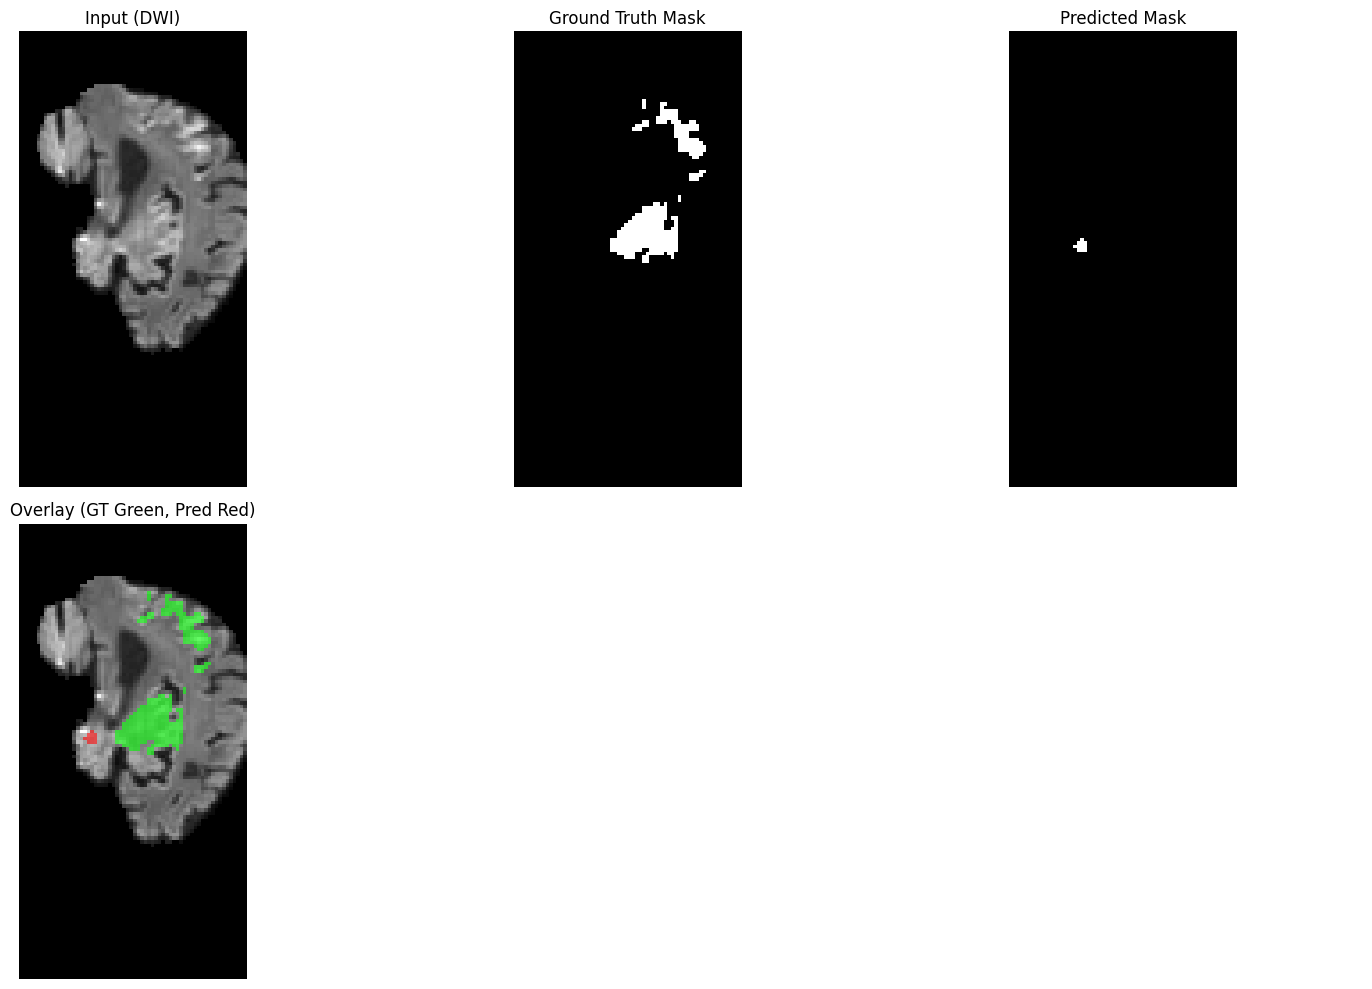

Sample 1: slice 75
  Ground Truth Slice shape: torch.Size([128, 64])
  Predicted Slice shape: torch.Size([128, 64])
  Dice score (ensemble): 0.6427
  Sample 1: AVD = 35.62%, Lesion-wise F1 = 0.760


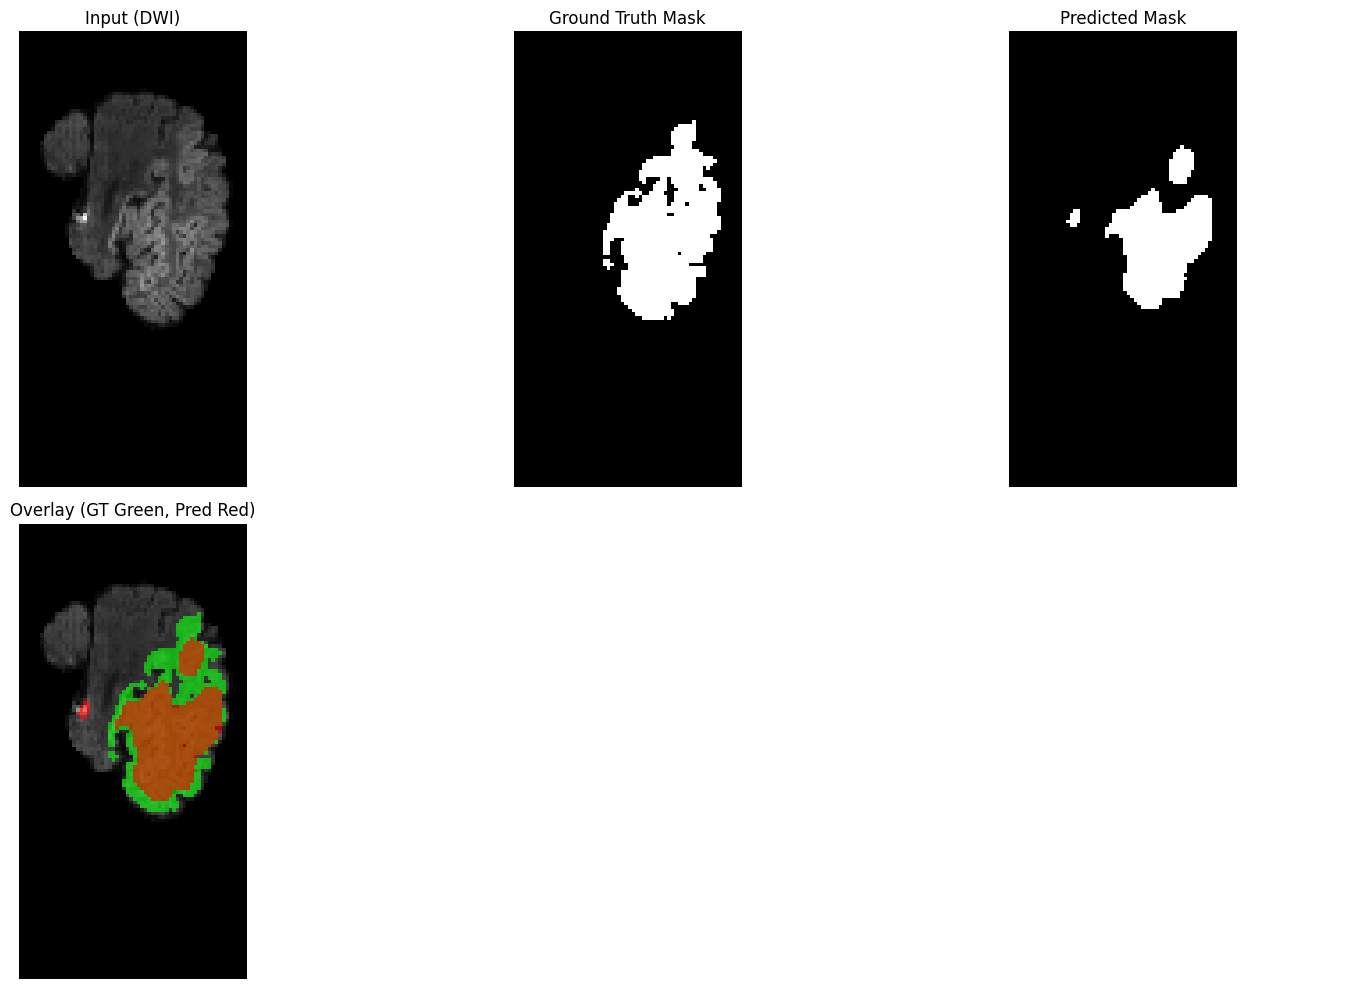

Sample 2: slice 58
  Ground Truth Slice shape: torch.Size([128, 64])
  Predicted Slice shape: torch.Size([128, 64])
  Dice score (ensemble): 0.0128
  Sample 2: AVD = 67.31%, Lesion-wise F1 = 0.928


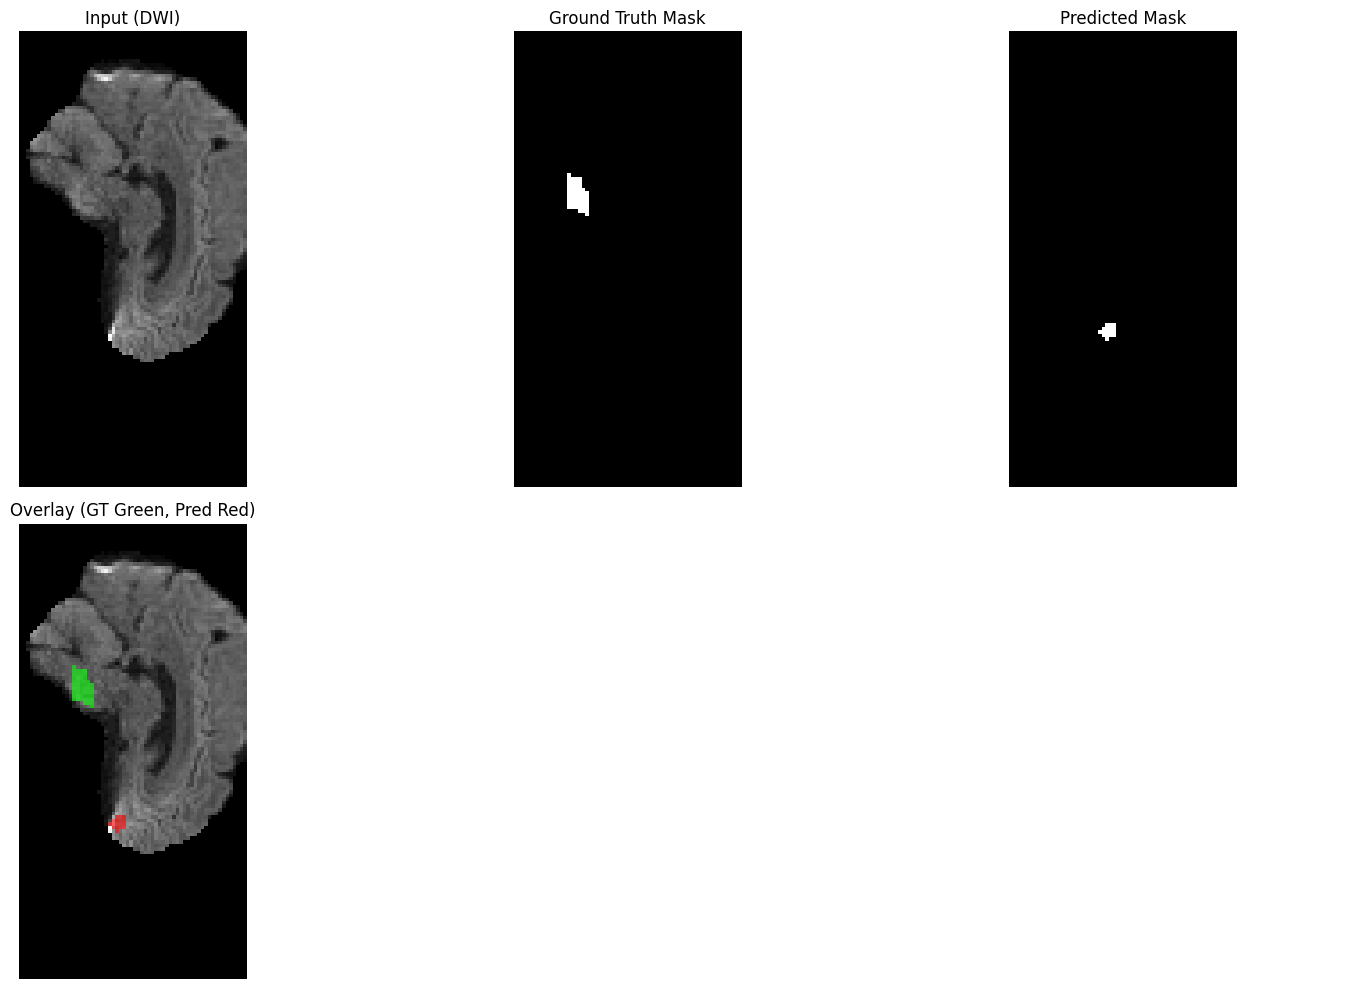

Sample 0: slice 73
  Ground Truth Slice shape: torch.Size([128, 64])
  Predicted Slice shape: torch.Size([128, 64])
  Dice score (ensemble): 0.0296
  Sample 0: AVD = 96.45%, Lesion-wise F1 = 0.914


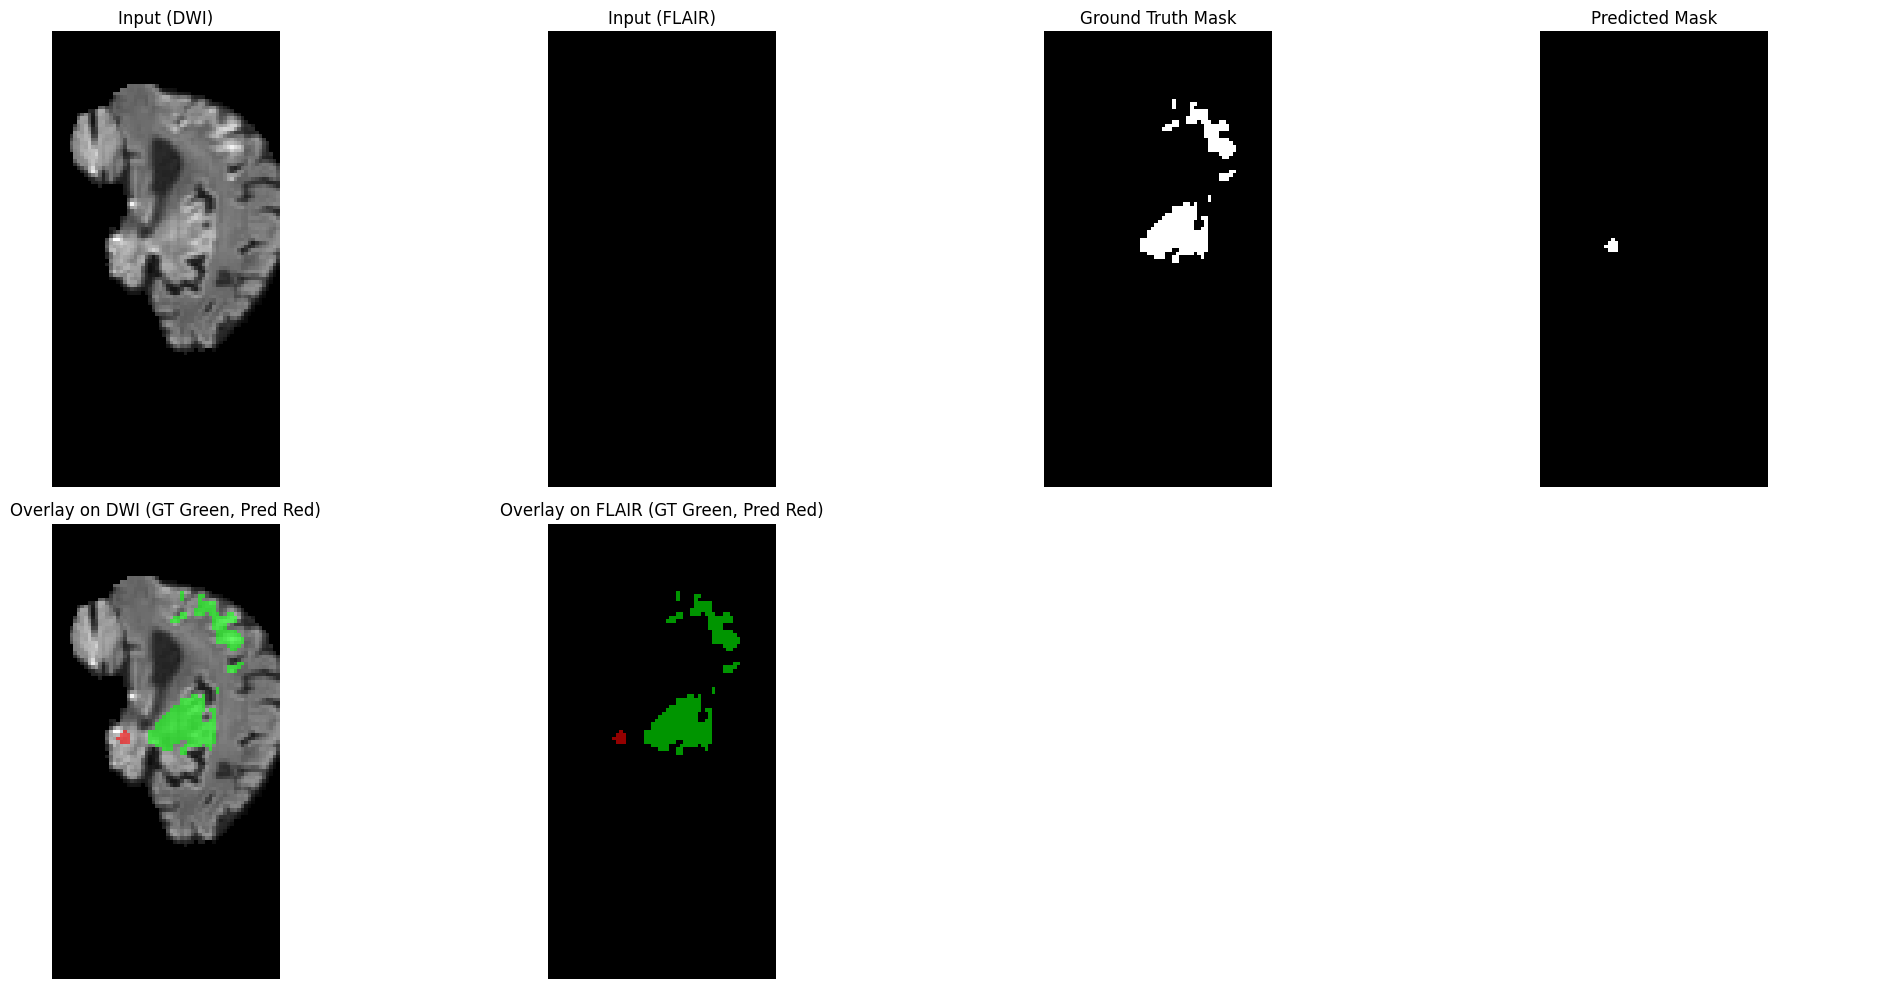

Sample 1: slice 75
  Ground Truth Slice shape: torch.Size([128, 64])
  Predicted Slice shape: torch.Size([128, 64])
  Dice score (ensemble): 0.6427
  Sample 1: AVD = 35.62%, Lesion-wise F1 = 0.760


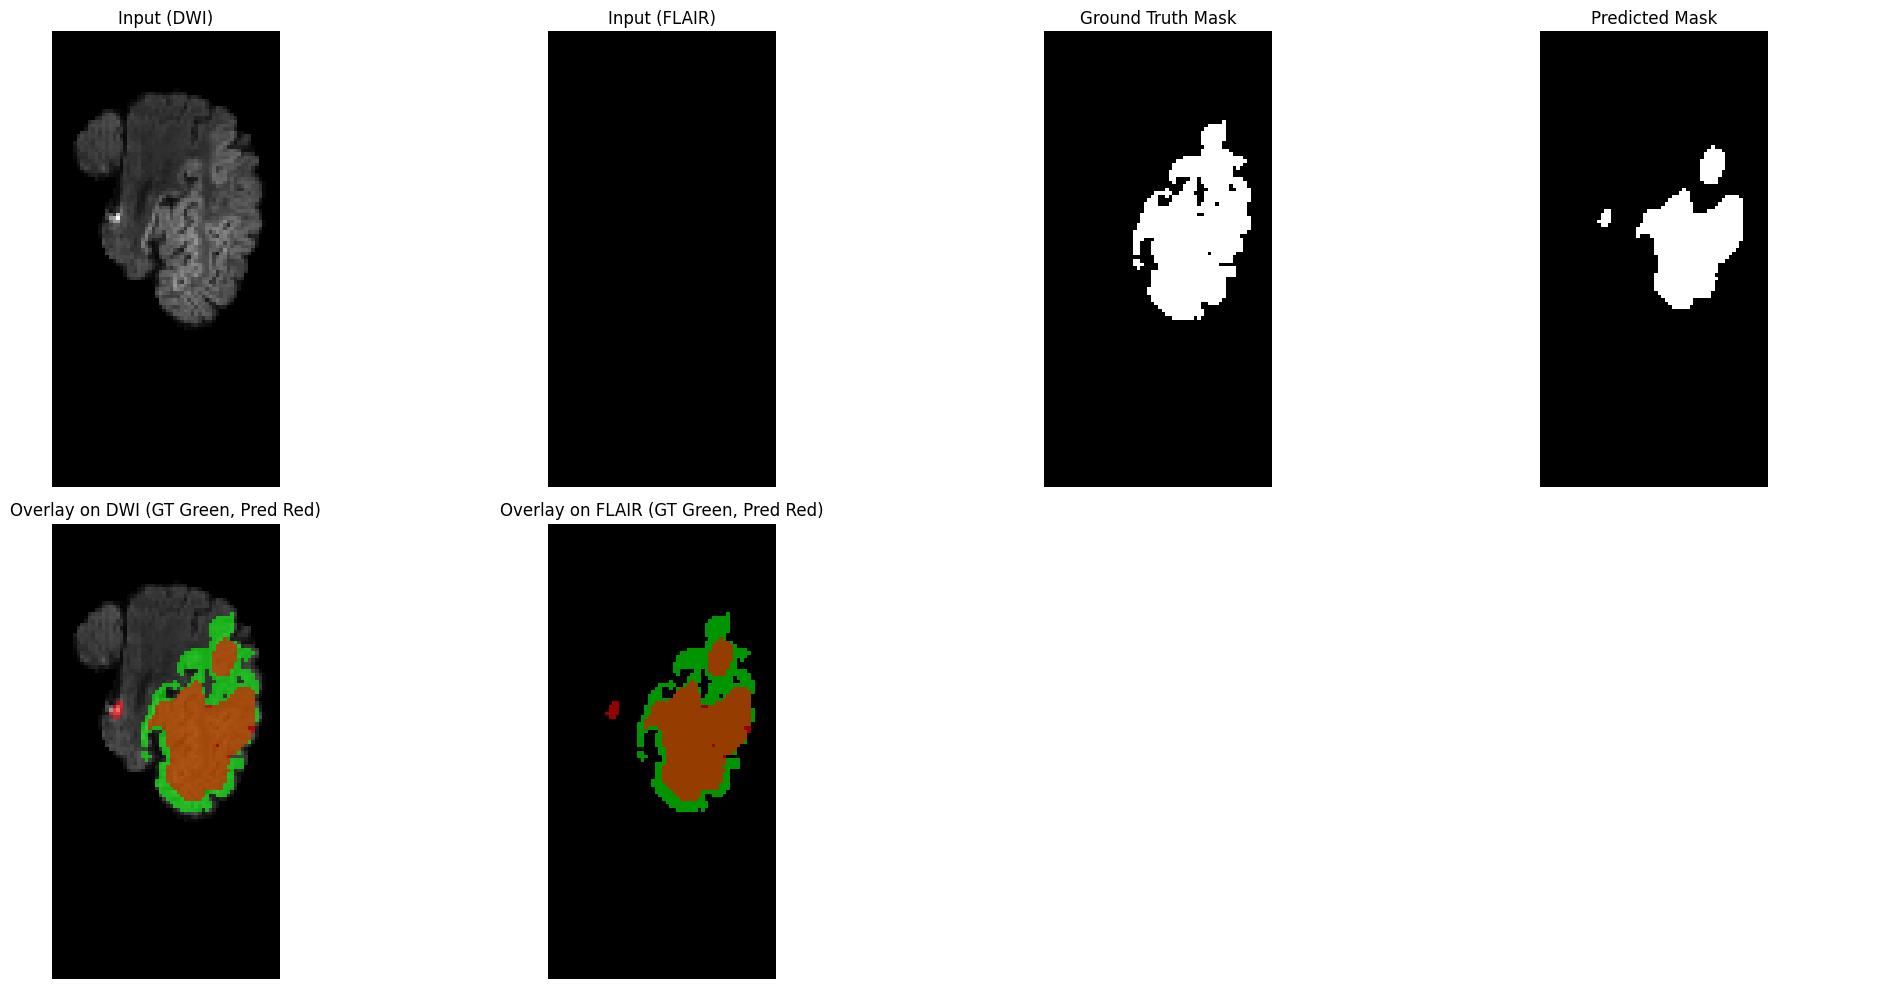

Sample 2: slice 58
  Ground Truth Slice shape: torch.Size([128, 64])
  Predicted Slice shape: torch.Size([128, 64])
  Dice score (ensemble): 0.0128
  Sample 2: AVD = 67.31%, Lesion-wise F1 = 0.928


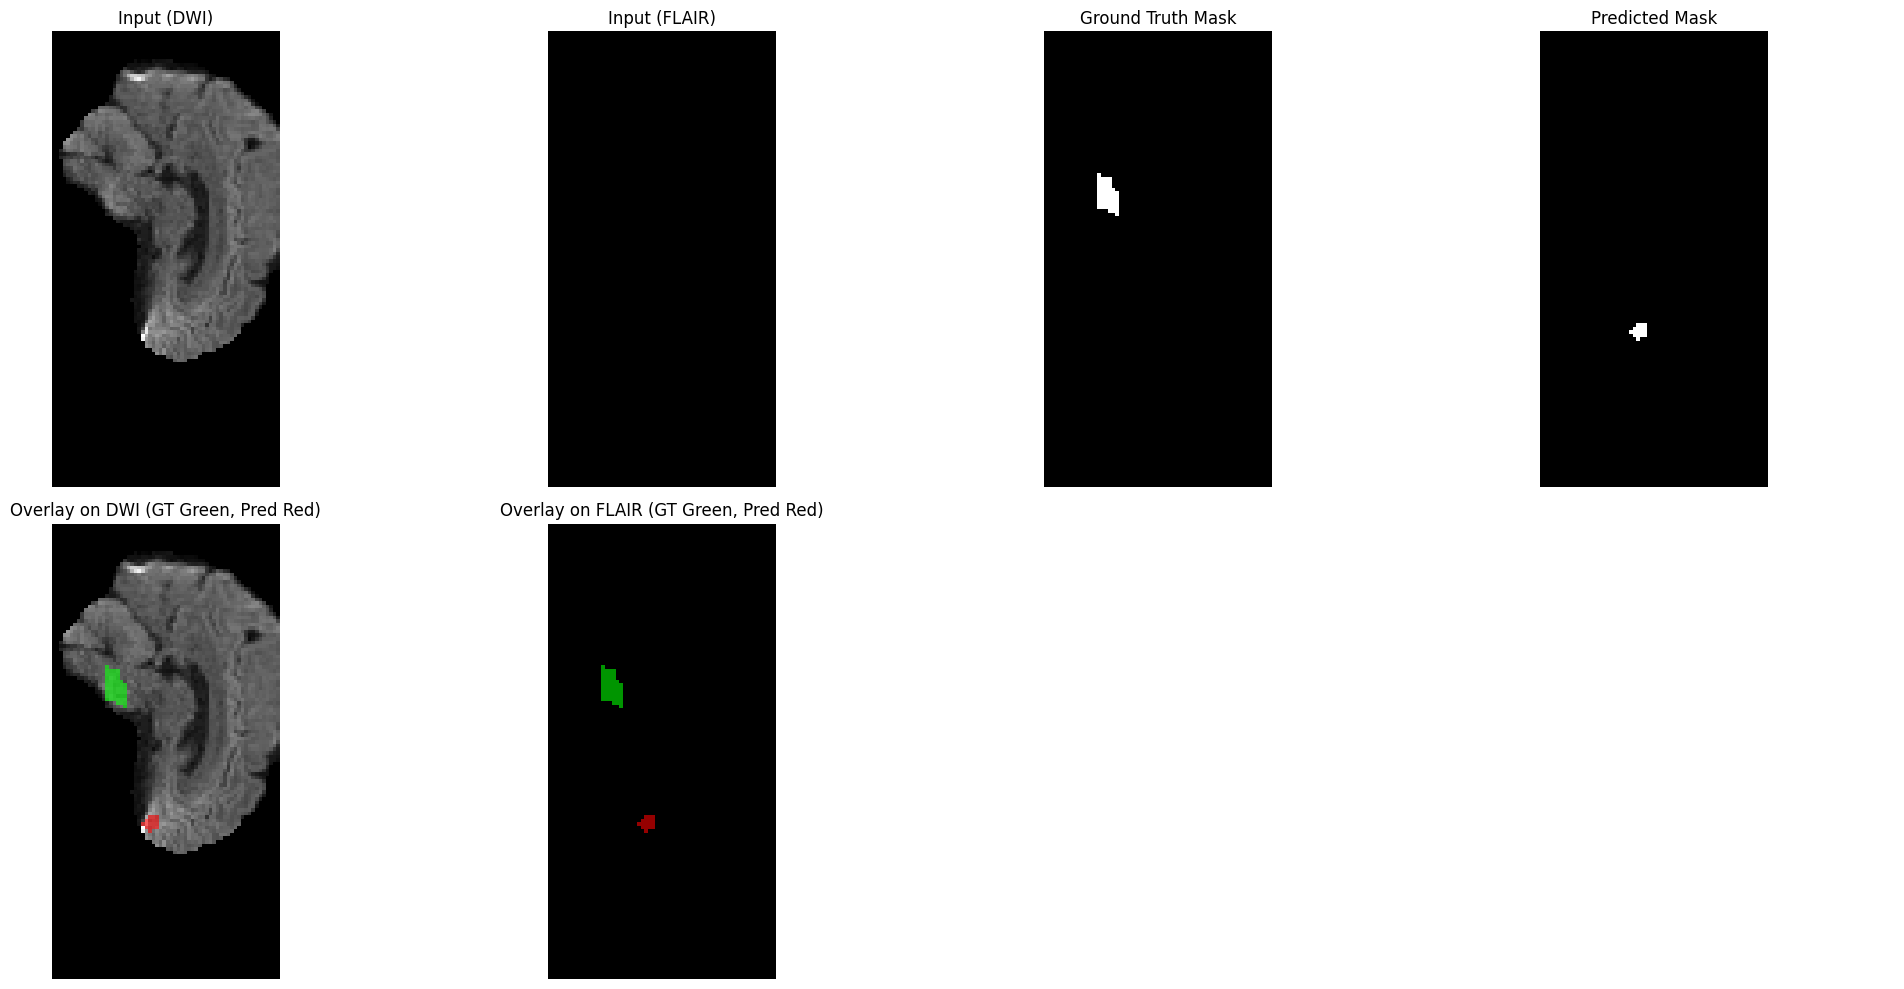

In [68]:
print(f"#Evaluate and visualize")

import matplotlib.pyplot as plt
import numpy as np

def plot_sample_combined_view(x_slice, y_slice, pred_slice, channel=0):
    """
    Plots input, ground truth mask, predicted mask separately and a colored overlay.

    Args:
        x_slice (torch.Tensor or np.ndarray): The input image slice.
                                             Shape [H, W] or [C, H, W].
        y_slice (torch.Tensor or np.ndarray): The ground truth mask slice.
                                             Shape [H, W]. Should be binary (0 or 1).
        pred_slice (torch.Tensor or np.ndarray): The predicted mask slice.
                                               Shape [H, W]. Should be binary (0 or 1).
        channel (int): The channel of the input image to display if it's multi-channel.
    """
    # Convert tensors to numpy arrays if they are not already
    if isinstance(x_slice, torch.Tensor):
        x_slice = x_slice.cpu().numpy()
    if isinstance(y_slice, torch.Tensor):
        y_slice = y_slice.cpu().numpy()
    if isinstance(pred_slice, torch.Tensor):
        pred_slice = pred_slice.cpu().numpy()

    # Select the desired channel of the input image to display for grayscale plots
    if x_slice.ndim == 3:
        input_img_display = x_slice[channel, :, :]
    elif x_slice.ndim == 2:
        input_img_display = x_slice
    else:
        print(f"Warning: Input slice has unexpected shape {x_slice.shape}. Displaying as is.")
        input_img_display = x_slice

    # Normalize the input image for display (optional)
    input_img_display = (input_img_display - input_img_display.min()) / (input_img_display.max() - input_img_display.min() + 1e-8)

    # Ensure masks are binary for consistent plotting
    y_slice_binary = (y_slice > 0.5)
    pred_slice_binary = (pred_slice > 0.5)

    # --- Create the figure and subplots ---
    fig, axes = plt.subplots(2, 3, figsize=(15, 10)) # 2 rows, 3 columns

    # --- Row 1: Separate Images ---

    # Plot Input Image (e.g., DWI)
    axes[0, 0].imshow(input_img_display, cmap='gray', interpolation='nearest')
    axes[0, 0].set_title("Input (DWI)")
    axes[0, 0].axis('off')

    # Plot Ground Truth Mask
    axes[0, 1].imshow(y_slice_binary, cmap='gray', interpolation='nearest')
    axes[0, 1].set_title("Ground Truth Mask")
    axes[0, 1].axis('off')

    # Plot Predicted Mask
    axes[0, 2].imshow(pred_slice_binary, cmap='gray', interpolation='nearest')
    axes[0, 2].set_title("Predicted Mask")
    axes[0, 2].axis('off')

    # --- Row 2: Colored Overlay ---

    # Plot Input Image as background for the overlay
    axes[1, 0].imshow(input_img_display, cmap='gray', interpolation='nearest')
    axes[1, 0].set_title("Overlay (GT Green, Pred Red)")
    axes[1, 0].axis('off') # Hide axes for the overlay plot

    # Overlay the ground truth mask in green (semi-transparent)
    gt_mask_rgba = np.zeros((*y_slice.shape, 4), dtype=np.uint8)
    gt_mask_rgba[y_slice_binary, 0] = 0    # Red channel
    gt_mask_rgba[y_slice_binary, 1] = 255  # Green channel
    gt_mask_rgba[y_slice_binary, 2] = 0    # Blue channel
    gt_mask_rgba[y_slice_binary, 3] = 150  # Alpha channel (transparency, 0-255)
    axes[1, 0].imshow(gt_mask_rgba) # Plot on the first subplot of the second row

    # Overlay the predicted mask in red (semi-transparent)
    pred_mask_rgba = np.zeros((*pred_slice.shape, 4), dtype=np.uint8)
    pred_mask_rgba[pred_slice_binary, 0] = 255  # Red channel
    pred_mask_rgba[pred_slice_binary, 1] = 0    # Green channel
    pred_mask_rgba[pred_slice_binary, 2] = 0    # Blue channel
    pred_mask_rgba[pred_slice_binary, 3] = 150  # Alpha channel (transparency, 0-255)
    axes[1, 0].imshow(pred_mask_rgba) # Plot on the first subplot of the second row

    # Turn off unused subplots in the second row
    axes[1, 1].axis('off')
    axes[1, 2].axis('off')


    plt.tight_layout() # Adjust layout
    plt.show()

# Get a batch
x, y = next(iter(train_loader)) # Get a new batch

# Apply the same preprocessing as in training
target_shape = (128, 128, 64) # Use the same target shape

if x.ndim == 4:
    x = x.unsqueeze(0)
if x.ndim == 5 and x.shape[1] > 2:
    x = x[:, :2, ...]
x = safe_pad_or_crop(x, target_shape)
x = x.to(DEVICE, dtype=torch.float)

y = safe_unsqueeze_mask(y)
y = safe_pad_or_crop(y, target_shape)
y = y.to(DEVICE, dtype=torch.float)
y = y.clamp(0, 1)

# Get the ensemble prediction
ensemble_models = load_ensemble(model_paths, DEVICE) # Ensure models are loaded
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)
for i in range(min(3, x.shape[0])):  # Show up to 3 samples
    # Find the slice with the largest mask area (improved selection)
    mask_3d = y[i, 0] if y.ndim == 5 else y[i]
    slice_sums = mask_3d.sum(dim=(-1, -2)) # Sum over Height and Width
    if torch.max(slice_sums) > 0: # Check if there is any lesion at all
        slice_idx = int(torch.argmax(slice_sums)) # Get the index of the max sum
    else:
        slice_idx = x.shape[2] // 2 # Fallback to middle if no lesion


    # Select the slice for visualization and evaluation
    x_slice = x[i, :, slice_idx, :, :].cpu().squeeze()  # [C, H, W] or [H, W]
    y_slice = mask_3d[slice_idx].cpu().squeeze()
    mask_slice = final_mask[i, 0, slice_idx, :, :].cpu().squeeze()

    print(f"Sample {i}: slice {slice_idx}")
    print(f"  Ground Truth Slice shape: {y_slice.shape}")
    print(f"  Predicted Slice shape: {mask_slice.shape}")
    print(f"  Dice score (ensemble): {dice_score(final_mask[i], y[i]).item():.4f}") # Calculate Dice on full 3D volume

    # Calculate AVD and F1 on the slices
    avd = absolute_volume_difference(mask_slice, y_slice)
    f1 = lesion_wise_f1_score(mask_slice, y_slice)
    print(f"  Sample {i}: AVD = {avd:.2f}%, Lesion-wise F1 = {f1:.3f}")

    # Call the new combined plotting function
    plot_sample_combined_view(x_slice, y_slice, mask_slice, channel=0) # Assuming channel 0 is DWI

    import matplotlib.pyplot as plt
import numpy as np

def plot_sample_combined_view_with_flair(x_slice, y_slice, pred_slice, channel_dwi=0, channel_flair=1):
    """
    Plots DWI, FLAIR, ground truth mask, predicted mask separately and a colored overlay.

    Args:
        x_slice (torch.Tensor or np.ndarray): The input image slice.
                                             Shape [C, H, W].
        y_slice (torch.Tensor or np.ndarray): The ground truth mask slice.
                                             Shape [H, W]. Should be binary (0 or 1).
        pred_slice (torch.Tensor or np.ndarray): The predicted mask slice.
                                               Shape [H, W]. Should be binary (0 or 1).
        channel_dwi (int): The channel index for the DWI image.
        channel_flair (int): The channel index for the FLAIR image.
    """
    # Convert tensors to numpy arrays if they are not already
    if isinstance(x_slice, torch.Tensor):
        x_slice = x_slice.cpu().numpy()
    if isinstance(y_slice, torch.Tensor):
        y_slice = y_slice.cpu().numpy()
    if isinstance(pred_slice, torch.Tensor):
        pred_slice = pred_slice.cpu().numpy()

    # Select the desired channels for display
    if x_slice.ndim == 3 and x_slice.shape[0] >= max(channel_dwi, channel_flair) + 1:
        input_dwi_display = x_slice[channel_dwi, :, :]
        input_flair_display = x_slice[channel_flair, :, :]
    else:
        print(f"Warning: Input slice has unexpected shape {x_slice.shape} or not enough channels.")
        return # Exit the function if channels are not available

    # Normalize the input images for display
    input_dwi_display = (input_dwi_display - input_dwi_display.min()) / (input_dwi_display.max() - input_dwi_display.min() + 1e-8)
    input_flair_display = (input_flair_display - input_flair_display.min()) / (input_flair_display.max() - input_flair_display.min() + 1e-8)

    # Ensure masks are binary for consistent plotting
    y_slice_binary = (y_slice > 0.5)
    pred_slice_binary = (pred_slice > 0.5)

    # --- Create the figure and subplots ---
    fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # 2 rows, 4 columns

    # --- Row 1: Separate Images ---

    # Plot Input Image (DWI)
    axes[0, 0].imshow(input_dwi_display, cmap='gray', interpolation='nearest')
    axes[0, 0].set_title("Input (DWI)")
    axes[0, 0].axis('off')

    # Plot Input Image (FLAIR)
    axes[0, 1].imshow(input_flair_display, cmap='gray', interpolation='nearest')
    axes[0, 1].set_title("Input (FLAIR)")
    axes[0, 1].axis('off')

    # Plot Ground Truth Mask
    axes[0, 2].imshow(y_slice_binary, cmap='gray', interpolation='nearest')
    axes[0, 2].set_title("Ground Truth Mask")
    axes[0, 2].axis('off')

    # Plot Predicted Mask
    axes[0, 3].imshow(pred_slice_binary, cmap='gray', interpolation='nearest')
    axes[0, 3].set_title("Predicted Mask")
    axes[0, 3].axis('off')

    # --- Row 2: Colored Overlay (using DWI as background) ---

    # Plot Input Image (DWI) as background for the overlay
    axes[1, 0].imshow(input_dwi_display, cmap='gray', interpolation='nearest')
    axes[1, 0].set_title("Overlay on DWI (GT Green, Pred Red)")
    axes[1, 0].axis('off') # Hide axes for the overlay plot

    # Overlay the ground truth mask in green (semi-transparent)
    gt_mask_rgba = np.zeros((*y_slice.shape, 4), dtype=np.uint8)
    gt_mask_rgba[y_slice_binary, 0] = 0    # Red channel
    gt_mask_rgba[y_slice_binary, 1] = 255  # Green channel
    gt_mask_rgba[y_slice_binary, 2] = 0    # Blue channel
    gt_mask_rgba[y_slice_binary, 3] = 150  # Alpha channel (transparency, 0-255)
    axes[1, 0].imshow(gt_mask_rgba) # Plot on the first subplot of the second row

    # Overlay the predicted mask in red (semi-transparent)
    pred_mask_rgba = np.zeros((*pred_slice.shape, 4), dtype=np.uint8)
    pred_mask_rgba[pred_slice_binary, 0] = 255  # Red channel
    pred_mask_rgba[pred_slice_binary, 1] = 0    # Green channel
    pred_mask_rgba[pred_slice_binary, 2] = 0    # Blue channel
    pred_mask_rgba[pred_slice_binary, 3] = 150  # Alpha channel (transparency, 0-255)
    axes[1, 0].imshow(pred_mask_rgba) # Plot on the first subplot of the second row

    # --- Row 2: Colored Overlay (using FLAIR as background) ---

    # Plot Input Image (FLAIR) as background for the overlay
    axes[1, 1].imshow(input_flair_display, cmap='gray', interpolation='nearest')
    axes[1, 1].set_title("Overlay on FLAIR (GT Green, Pred Red)")
    axes[1, 1].axis('off') # Hide axes for the overlay plot

    # Overlay the ground truth mask in green (semi-transparent) on FLAIR
    axes[1, 1].imshow(gt_mask_rgba)

    # Overlay the predicted mask in red (semi-transparent) on FLAIR
    axes[1, 1].imshow(pred_mask_rgba)

    # Turn off unused subplots in the second row
    axes[1, 2].axis('off')
    axes[1, 3].axis('off')


    plt.tight_layout() # Adjust layout
    plt.show()

# ... (your existing code for loading data, models, and making predictions) ...

# In the evaluation loop, replace the call to plot_sample_combined_view with:

for i in range(min(3, x.shape[0])):  # Show up to 3 samples
    # Find the slice with the largest mask area (improved selection)
    mask_3d = y[i, 0] if y.ndim == 5 else y[i]
    slice_sums = mask_3d.sum(dim=(-1, -2)) # Sum over Height and Width
    if torch.max(slice_sums) > 0: # Check if there is any lesion at all
        slice_idx = int(torch.argmax(slice_sums)) # Get the index of the max sum
    else:
        slice_idx = x.shape[2] // 2 # Fallback to middle if no lesion


    # Select the slice for visualization and evaluation
    x_slice = x[i, :, slice_idx, :, :].cpu().squeeze()  # [C, H, W]
    y_slice = mask_3d[slice_idx].cpu().squeeze()
    mask_slice = final_mask[i, 0, slice_idx, :, :].cpu().squeeze()

    print(f"Sample {i}: slice {slice_idx}")
    print(f"  Ground Truth Slice shape: {y_slice.shape}")
    print(f"  Predicted Slice shape: {mask_slice.shape}")
    print(f"  Dice score (ensemble): {dice_score(final_mask[i], y[i]).item():.4f}") # Calculate Dice on full 3D volume

    # Calculate AVD and F1 on the slices
    avd = absolute_volume_difference(mask_slice, y_slice)
    f1 = lesion_wise_f1_score(mask_slice, y_slice)
    print(f"  Sample {i}: AVD = {avd:.2f}%, Lesion-wise F1 = {f1:.3f}")

    # Call the new combined plotting function including FLAIR
    # Assuming channel 0 is DWI and channel 1 is FLAIR
    plot_sample_combined_view_with_flair(x_slice, y_slice, mask_slice, channel_dwi=0, channel_flair=1)


In [70]:
print(f"# Printing Ensemble Model Statistics and Parameters")

# Assuming ensemble_models is already loaded:
# model_paths = [drive_path+f"/base_model_{i}.pth" for i in range(N_MODELS)]
# ensemble_models = load_ensemble(model_paths, DEVICE)

if not ensemble_models:
    print("Ensemble models have not been loaded yet.")
else:
    print(f"Ensemble consists of {len(ensemble_models)} individual models.")
    for i, model in enumerate(ensemble_models):
        print(f"\n--- Model {i} ---")

        # 1. Model Architecture/Structure
        print("Architecture:")
        # Printing the model directly gives a summary of its layers
        print(model)

        # 2. Total Number of Parameters
        total_params = sum(p.numel() for p in model.parameters())
        print(f"\nTotal parameters: {total_params}")

        # 3. Trainable Parameters
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters: {trainable_params}")

        # 4. Parameters by Layer (Optional - can be very verbose)
        print("\nParameters per layer (Trainable Only):")
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"  {name}: {param.numel()} parameters")

        # 5. Example Parameter Values (Optional - gives a peek into learned weights)
        print("\nExample parameter values (first layer weights):")
        try:
            # Find a convolutional layer to show its weights
            # This assumes the first layer is a Conv3d, adjust if needed
            first_conv_weights = None
            for module in model.modules():
                if isinstance(module, nn.Conv3d):
                    first_conv_weights = module.weight.data
                    break
            if first_conv_weights is not None:
                 # Print shape and some values (e.g., mean, std, min, max)
                 print(f"  Shape: {first_conv_weights.shape}")
                 print(f"  Mean: {torch.mean(first_conv_weights):.6f}")
                 print(f"  Std: {torch.std(first_conv_weights):.6f}")
                 print(f"  Min: {torch.min(first_conv_weights):.6f}")
                 print(f"  Max: {torch.max(first_conv_weights):.6f}")
            else:
                 print("  Could not find a Conv3d layer.")

        except Exception as e:
            print(f"  Could not display example parameters: {e}")

    print("\n--- Ensemble Summary ---")
    print(f"Ensemble combines predictions from {len(ensemble_models)} models.")
    # Add any other ensemble-level information you want to print,
    # e.g., the combination method (averaging in this case).
    print("Combination method: Averaging predicted probabilities.")

# Printing Ensemble Model Statistics and Parameters
Ensemble consists of 5 individual models.

--- Model 0 ---
Architecture:
UNet3D(
  (downs): ModuleList(
    (0): DoubleConv3D(
      (double_conv): Sequential(
        (0): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv3D(
      (double_conv): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1,